# Project 1: Time Series Forecasting with XGBoost

I have recently participated to my first Kaggle competition: "Recruit Restaurant Visitors Forecasting". I ended up in the top 79% with a Root Mean Squared Log Error of .58 (a team won the competition with .505).

The aim of this project is to consolidate and share the knowledge acquired with my first competition. To do this, I decided not to share the feed-forward neural net I used to create my Kaggle submissions. I decided instead to create a new Jupyter Notebook to learn new things.

So this notebook is a reworked version of Max Halford's Notebook (he ended the competition at the 8th place). I changed it, added new features and trained a different model.

I learned a ton. Thanks Max.

In [1]:
## Show matplotlib figures without using plt.show()
%matplotlib inline

## Import packages
import glob
import itertools

## Core Packages
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

## Function to calculate distance between a couple of coordinates
from geopy.distance import vincenty

## XGB
import xgboost as xgb

I load a preprocessed version of air_store_info: a version that contains weather station data (useful to join with weather data).

In [2]:
# Import Data
data = {"air_store_info": pd.read_csv("data/weather/air_store_info_with_nearest_active_station.csv"),
        "air_visit_data": pd.read_csv("data/kaggle/air_visit_data.csv", parse_dates=[1]),
       "date_info": pd.read_csv("data/kaggle/date_info.csv", parse_dates=[0]),
       "air_reserve": pd.read_csv("data/kaggle/air_reserve.csv", parse_dates=[1,2]),
       "hpg_reserve": pd.read_csv("data/kaggle/hpg_reserve.csv", parse_dates=[1,2]),
       "hpg_store_info": pd.read_csv("data/kaggle/hpg_store_info.csv"),
       "store_id_relation": pd.read_csv("data/kaggle/store_id_relation.csv"),
       "sample_submission": pd.read_csv("data/kaggle/sample_submission.csv")}

## Time Features

The first thing I am going to do here is to process air_visit_data in order to obtain 0 visitors for the days where there are no data points. This will allow us to have the same number of observations for each restaurant.

In [3]:
## Process df to obtain 0 visitors for the days where there are no data points. In addition, every restaurant has the
## same number of data points.
data["air_visit_data"] = data["air_visit_data"].set_index(["visit_date","air_store_id"]).unstack("air_store_id")
data["air_visit_data"] = data["air_visit_data"].stack("air_store_id", dropna=False).reset_index()
data["air_visit_data"]["was_null"] = data["air_visit_data"].visitors.isnull()
data["air_visit_data"].visitors.fillna(0, inplace=True)
## Show first 5 rows of processed df
data["air_visit_data"].head()

,visit_date,air_store_id,visitors,was_null
0,2016-01-01,air_00a91d42b08b08d9,0.0,True
1,2016-01-01,air_0164b9927d20bcc3,0.0,True
2,2016-01-01,air_0241aa3964b7f861,0.0,True
3,2016-01-01,air_0328696196e46f18,0.0,True
4,2016-01-01,air_034a3d5b40d5b1b1,0.0,True


Let's create the following simple and potentially useful features:

- prev_day_is_holiday
- next_day_is_holiday

In [4]:
## Rename Columns for convenience
data["date_info"].rename(columns={"holiday_flg":"is_holiday", "calendar_date":"visit_date"}, inplace=True)
## Create new features
data["date_info"]["prev_day_is_holiday"] = data["date_info"].is_holiday.shift().fillna(0)
data["date_info"]["next_day_is_holiday"] = data["date_info"].is_holiday.shift(-1).fillna(0)
## Show first 5 rows of date_info
data["date_info"].head()

,visit_date,day_of_week,is_holiday,prev_day_is_holiday,next_day_is_holiday
0,2016-01-01,Friday,1,0.0,1.0
1,2016-01-02,Saturday,1,1.0,1.0
2,2016-01-03,Sunday,1,1.0,0.0
3,2016-01-04,Monday,0,1.0,0.0
4,2016-01-05,Tuesday,0,0.0,0.0


Now we merge the air_visit_data with the calendar and store information.

In [5]:
## Left Joins
df = pd.merge(data["air_visit_data"], data["date_info"], on="visit_date", how="left")
df = pd.merge(df, data["air_store_info"], on="air_store_id", how="left")
## Show first 5 rows of result
df.head()

,visit_date,air_store_id,visitors,was_null,day_of_week,is_holiday,prev_day_is_holiday,next_day_is_holiday,air_genre_name,air_area_name,latitude,longitude,latitude_str,longitude_str,station_id,station_latitude,station_longitude,station_vincenty,station_great_circle
0,2016-01-01,air_00a91d42b08b08d9,0.0,True,Friday,1,0.0,1.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.750000,0.416011,0.415906
1,2016-01-01,air_0164b9927d20bcc3,0.0,True,Friday,1,0.0,1.0,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,"""35.6580681""","""139.7515992""",tokyo__tokyo-kana__tonokyo,35.691667,139.750000,3.730672,3.739835
2,2016-01-01,air_0241aa3964b7f861,0.0,True,Friday,1,0.0,1.0,Izakaya,Tōkyō-to Taitō-ku Higashiueno,35.712607,139.779996,"""35.712607""","""139.7799956""",tokyo__tokyo-kana__tonokyo,35.691667,139.750000,3.573166,3.572811
3,2016-01-01,air_0328696196e46f18,0.0,True,Friday,1,0.0,1.0,Dining bar,Ōsaka-fu Ōsaka-shi Nakanochō,34.701279,135.528090,"""34.7012792""","""135.5280905""",osaka__osaka-kana__osaka,34.681667,135.518333,2.352244,2.356879
4,2016-01-01,air_034a3d5b40d5b1b1,0.0,True,Friday,1,0.0,1.0,Cafe/Sweets,Ōsaka-fu Ōsaka-shi Ōhiraki,34.692337,135.472229,"""34.6923371""","""135.4722289""",osaka__osaka-kana__osaka,34.681667,135.518333,4.387452,4.380478


Now I will create the following features:
- day
- month
- is_weekend 

In [6]:
## Create time features
df["is_weekend"] = df.day_of_week.isin(["Saturday", "Sunday"]).astype(int)
df["day"] = df.visit_date.dt.day
df["month"] = df.visit_date.dt.month

## Weather Features

Let's load the preprocessed weather data.

In [7]:
## Load weather data
list_of_weather_dfs = []

for path in glob.glob('data/weather/1-1-16_5-31-17_Weather/*.csv'):
    weather_df = pd.read_csv(path)
    weather_df["station_id"] = path.split('/')[-1].rstrip('.csv')
    list_of_weather_dfs.append(weather_df)

weather = pd.concat(list_of_weather_dfs, axis=0)
weather.rename(columns={"calendar_date":"visit_date"}, inplace=True)
weather.head()

,visit_date,avg_temperature,high_temperature,low_temperature,precipitation,hours_sunlight,solar_radiation,deepest_snowfall,total_snowfall,avg_wind_speed,avg_vapor_pressure,avg_local_pressure,avg_humidity,avg_sea_pressure,cloud_cover,station_id
0,2016-01-01,6.0,11.0,0.7,0.0,9.1,NaN,NaN,NaN,2.9,NaN,NaN,NaN,NaN,NaN,aichi__ai-xi-kana__isaai
1,2016-01-02,4.7,10.5,0.0,0.0,6.8,NaN,NaN,NaN,1.4,NaN,NaN,NaN,NaN,NaN,aichi__ai-xi-kana__isaai
2,2016-01-03,7.0,13.8,1.9,0.0,8.6,NaN,NaN,NaN,1.4,NaN,NaN,NaN,NaN,NaN,aichi__ai-xi-kana__isaai
3,2016-01-04,8.8,14.7,2.7,0.0,5.3,NaN,NaN,NaN,2.2,NaN,NaN,NaN,NaN,NaN,aichi__ai-xi-kana__isaai
4,2016-01-05,8.9,14.1,3.4,0.0,4.5,NaN,NaN,NaN,2.7,NaN,NaN,NaN,NaN,NaN,aichi__ai-xi-kana__isaai


We are going use temperature and precipitation features. But these features contain missing values that we are going to replace with the global daily average (a better way would have been calculating the average of the n closest stations to each restaurant).

In [8]:
## Calculate averages
avg = weather.groupby("visit_date")[["avg_temperature", "precipitation"]].mean().reset_index()
## Rename Columns
avg.rename(columns={"avg_temperature":"global_avg_temp", "precipitation":"avg_precipitation"}, inplace=True)
## Join averages
weather = pd.merge(weather, avg, on="visit_date", how="left")
## Fill NaNs
weather.avg_temperature.fillna(weather.global_avg_temp, inplace=True)
weather.precipitation.fillna(weather.avg_precipitation, inplace=True)
## Cast visit_date column to datetime
weather.visit_date = pd.to_datetime(weather.visit_date)
## Show head of df
weather.head()

,visit_date,avg_temperature,high_temperature,low_temperature,precipitation,hours_sunlight,solar_radiation,deepest_snowfall,total_snowfall,avg_wind_speed,avg_vapor_pressure,avg_local_pressure,avg_humidity,avg_sea_pressure,cloud_cover,station_id,global_avg_temp,avg_precipitation
0,2016-01-01,6.0,11.0,0.7,0.0,9.1,NaN,NaN,NaN,2.9,NaN,NaN,NaN,NaN,NaN,aichi__ai-xi-kana__isaai,2.868353,0.564662
1,2016-01-02,4.7,10.5,0.0,0.0,6.8,NaN,NaN,NaN,1.4,NaN,NaN,NaN,NaN,NaN,aichi__ai-xi-kana__isaai,5.279225,2.341998
2,2016-01-03,7.0,13.8,1.9,0.0,8.6,NaN,NaN,NaN,1.4,NaN,NaN,NaN,NaN,NaN,aichi__ai-xi-kana__isaai,6.589978,1.750616
3,2016-01-04,8.8,14.7,2.7,0.0,5.3,NaN,NaN,NaN,2.2,NaN,NaN,NaN,NaN,NaN,aichi__ai-xi-kana__isaai,5.857883,1.644946
4,2016-01-05,8.9,14.1,3.4,0.0,4.5,NaN,NaN,NaN,2.7,NaN,NaN,NaN,NaN,NaN,aichi__ai-xi-kana__isaai,4.556850,3.193625


In [9]:
## Join weather to df
df = pd.merge(df, weather[["station_id", "visit_date", "avg_temperature", "precipitation"]],
              on=["station_id","visit_date"], how="left")
## Show head of df
df.head()

,visit_date,air_store_id,visitors,was_null,day_of_week,is_holiday,prev_day_is_holiday,next_day_is_holiday,air_genre_name,air_area_name,...,station_id,station_latitude,station_longitude,station_vincenty,station_great_circle,is_weekend,day,month,avg_temperature,precipitation
0,2016-01-01,air_00a91d42b08b08d9,0.0,True,Friday,1,0.0,1.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,...,tokyo__tokyo-kana__tonokyo,35.691667,139.750000,0.416011,0.415906,0,1,1,7.5,0.564662
1,2016-01-01,air_0164b9927d20bcc3,0.0,True,Friday,1,0.0,1.0,Italian/French,Tōkyō-to Minato-ku Shibakōen,...,tokyo__tokyo-kana__tonokyo,35.691667,139.750000,3.730672,3.739835,0,1,1,7.5,0.564662
2,2016-01-01,air_0241aa3964b7f861,0.0,True,Friday,1,0.0,1.0,Izakaya,Tōkyō-to Taitō-ku Higashiueno,...,tokyo__tokyo-kana__tonokyo,35.691667,139.750000,3.573166,3.572811,0,1,1,7.5,0.564662
3,2016-01-01,air_0328696196e46f18,0.0,True,Friday,1,0.0,1.0,Dining bar,Ōsaka-fu Ōsaka-shi Nakanochō,...,osaka__osaka-kana__osaka,34.681667,135.518333,2.352244,2.356879,0,1,1,7.6,0.000000
4,2016-01-01,air_034a3d5b40d5b1b1,0.0,True,Friday,1,0.0,1.0,Cafe/Sweets,Ōsaka-fu Ōsaka-shi Ōhiraki,...,osaka__osaka-kana__osaka,34.681667,135.518333,4.387452,4.380478,0,1,1,7.6,0.000000


In [10]:
## Have a brief look at the statistical properties of numerical features
df.describe()

,visitors,is_holiday,prev_day_is_holiday,next_day_is_holiday,latitude,longitude,station_latitude,station_longitude,station_vincenty,station_great_circle,is_weekend,day,month,avg_temperature,precipitation
count,396262.000000,396262.000000,396262.000000,396262.000000,396262.000000,396262.000000,396262.000000,396262.000000,396262.000000,396262.000000,396262.000000,396262.000000,396262.000000,396262.000000,396262.000000
mean,13.343831,0.064854,0.064854,0.062762,35.647042,137.415311,35.648388,137.414841,3.831249,3.831433,0.286611,15.518828,5.548117,14.047991,4.893447
std,16.746942,0.246268,0.246268,0.242534,2.083404,3.648773,2.083278,3.648427,2.215260,2.215166,0.452179,8.739539,3.527658,8.443810,12.196012
min,0.000000,0.000000,0.000000,0.000000,33.211967,130.195555,33.225000,130.190000,0.416011,0.415906,0.000000,1.000000,1.000000,-18.800000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,34.695124,135.341564,34.681667,135.335000,1.939005,1.936238,0.000000,8.000000,3.000000,7.100000,0.000000
50%,8.000000,0.000000,0.000000,0.000000,35.658068,139.685474,35.691667,139.620000,3.575241,3.578453,0.000000,15.000000,5.000000,13.100000,0.933473
75%,21.000000,0.000000,0.000000,0.000000,35.694003,139.751599,35.691667,139.750000,5.319959,5.318636,1.000000,23.000000,9.000000,21.400000,3.500000
max,877.000000,1.000000,1.000000,1.000000,44.020632,144.273398,44.016667,144.278333,12.217263,12.189999,1.000000,31.000000,12.000000,32.400000,208.000000


## Dependent Variable and Outliers

Visitors has range: 877 and mean: 13 so the distribution has a long right tail. Let's plot it below.

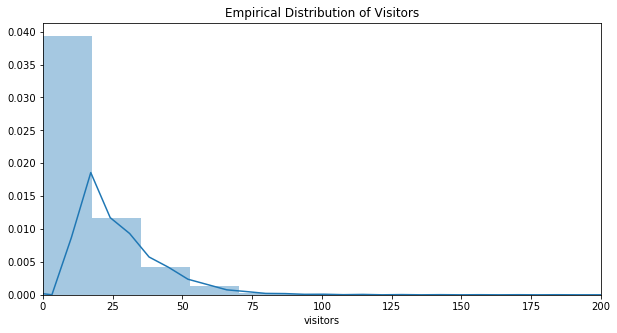

In [11]:
## Plot empirical distribution of visitors
plt.figure(figsize=(10,5))
plt.title("Empirical Distribution of Visitors")
sns.distplot(df.visitors)
## Let's break the x axis at 200 for convenience
plt.xlim(0,200)
plt.show()

We will predict $\ln(1+visitors)$ instead of the pure number of visitors so let's have a look at the transformed distribution.

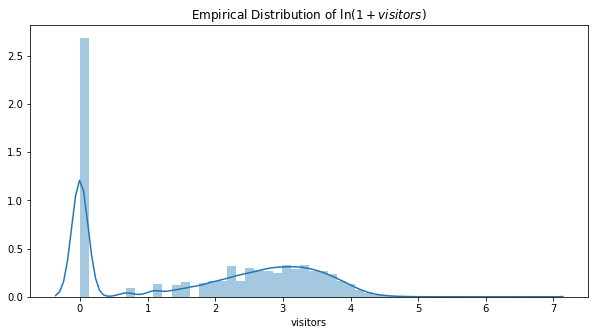

In [12]:
## Plot empirical distribution of log(1+visitors)
plt.figure(figsize=(10,5))
plt.title("Empirical Distribution of $\ln(1+visitors)$")
sns.distplot(df.visitors.apply(np.log1p))
plt.show()

To get a sense of how many potential outliers we are dealing with I use a strip-plot of the number of visitors per day.

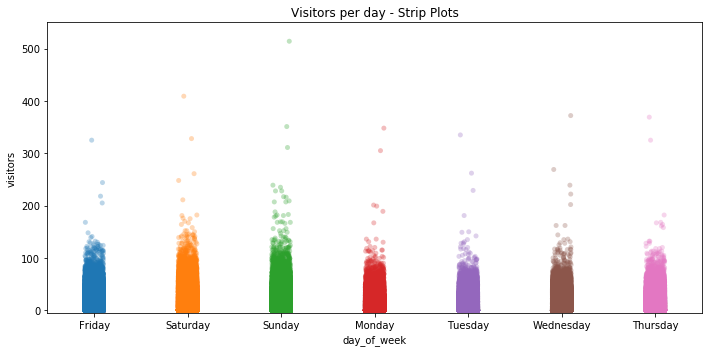

In [13]:
## Plot visitors per day using strip-plots
plt.figure(figsize=(10,5))
plt.title("Visitors per day - Strip Plots")
sns.stripplot(x="day_of_week", y="visitors", data=df, jitter=True, alpha=0.3)
## Let's break the y axis at 550 for convenience (there exist data point even above this threshold)
plt.ylim((-5,550))
plt.tight_layout()

To appreciate how the conditional distribution of visitors changes as day_of_week changes I use the box-plot below.

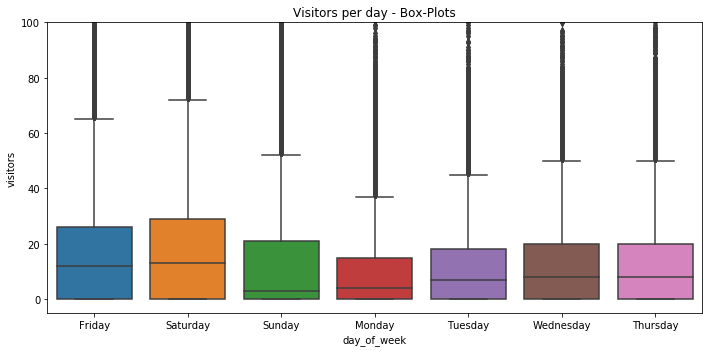

In [14]:
## Plot visitors per day using box-plots
plt.figure(figsize=(10,5))
plt.title("Visitors per day - Box-Plots")
sns.boxplot(x="day_of_week", y="visitors", data=df)
## Let's break the y axis at 100 for convenience (there exist data point even above this threshold)
plt.ylim((-5,100))
plt.tight_layout()

We now address the problem of outliers identifying them as datapoints that are greater than 4 times the standard deviation of the empirical distribution. Since the distribution of visitors changes if we condition on day_of_week, we are going to identify outliers using conditional distributions' statistics. Finally I am going to cap outliers using the maximum value among non-outliers. I will also create a log(1+visitors_capped) feature.

In [15]:
## Function to identify outliers
def find_outliers(series):
    """Takes a Pandas Series as input and returns a boolean series that identifies outliers"""
    return (series - series.mean()) > 4 * series.std()

## Function to cap outliers
def cap_values(series):
    """Takes a Pandas Series as input, finds outliers and caps them with the max among non outliers.
    Returns capped series."""
    outliers = find_outliers(series)
    max_val = series[~outliers].max()
    series[outliers] = max_val
    return series

In [16]:
## Create groupby object and apply custom functions
grouped = df.groupby(by=["air_store_id", "day_of_week"])["visitors"]
df["outlier"] = grouped.apply(find_outliers)
df["visitors_capped"] = grouped.apply(cap_values)
df["visitors_capped_log1p"] = df.visitors_capped.apply(np.log1p)

In [17]:
# Sort df by date and id
df.sort_values(by=["visit_date","air_store_id",], inplace=True)
## Show head
df.head()

,visit_date,air_store_id,visitors,was_null,day_of_week,is_holiday,prev_day_is_holiday,next_day_is_holiday,air_genre_name,air_area_name,...,station_vincenty,station_great_circle,is_weekend,day,month,avg_temperature,precipitation,outlier,visitors_capped,visitors_capped_log1p
0,2016-01-01,air_00a91d42b08b08d9,0.0,True,Friday,1,0.0,1.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,...,0.416011,0.415906,0,1,1,7.5,0.564662,False,0.0,0.0
1,2016-01-01,air_0164b9927d20bcc3,0.0,True,Friday,1,0.0,1.0,Italian/French,Tōkyō-to Minato-ku Shibakōen,...,3.730672,3.739835,0,1,1,7.5,0.564662,False,0.0,0.0
2,2016-01-01,air_0241aa3964b7f861,0.0,True,Friday,1,0.0,1.0,Izakaya,Tōkyō-to Taitō-ku Higashiueno,...,3.573166,3.572811,0,1,1,7.5,0.564662,False,0.0,0.0
3,2016-01-01,air_0328696196e46f18,0.0,True,Friday,1,0.0,1.0,Dining bar,Ōsaka-fu Ōsaka-shi Nakanochō,...,2.352244,2.356879,0,1,1,7.6,0.000000,False,0.0,0.0
4,2016-01-01,air_034a3d5b40d5b1b1,0.0,True,Friday,1,0.0,1.0,Cafe/Sweets,Ōsaka-fu Ōsaka-shi Ōhiraki,...,4.387452,4.380478,0,1,1,7.6,0.000000,False,0.0,0.0


## Competition Features

Let's first calculate and plot the geo distribution of restaurants.

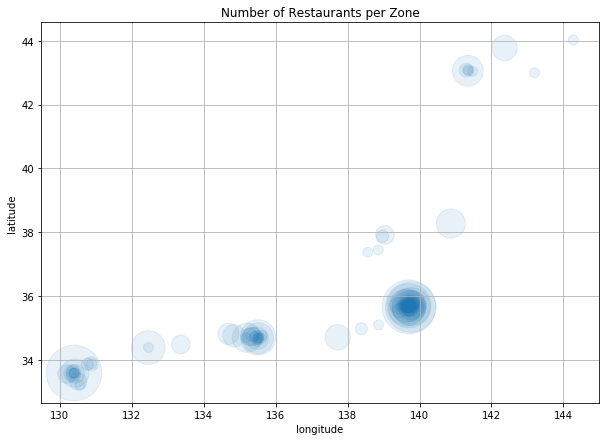

In [18]:
## Calculate number of restaurants per zone
## Just keep useful columns
restaurants = df[["latitude", "longitude", "air_store_id"]].copy()
# Group-by and count distinct
restaurant_per_zone = restaurants.groupby(by=["longitude", "latitude"]).nunique().drop(["latitude", "longitude"]
                                                                                       ,axis=1).reset_index()
## Rename column
restaurant_per_zone.rename(columns={"air_store_id": "n_rest_zone"}, inplace=True)
## Plot dist
restaurant_per_zone.plot(kind="scatter", x="longitude", y="latitude",
                         s=restaurant_per_zone.n_rest_zone*50,alpha=0.1, figsize=(10,7), grid=True,
                        title="Number of Restaurants per Zone")

As we can see there are places with greater restaurant concentration. Greater concentration does not necessarily mean greater competition but competition could affect the number of visitors. With this in mind I create the following new set of features:

- n_rest_kind_zone: number of restauraurants of a given kind in a zone
- distance_from_nearest: distance in km from nearest zone
- n_rest_nearest_zone: number of restaurants in nearest zone
- n_rest_kind_nearest_zone: number of restaurants of a given kind in the nearest zone
- demand_zone_kind: avg n. of visitors per kind of restaurant and day in a give area
- demand_zone_kind_nearest: avg n. of visitors per kind of restaurant and day in the nearest zone

In [19]:
## Calculate number and kind of restaurants per zone
## Just keep useful columns
restaurants_kind = df[["latitude", "longitude","air_genre_name", "air_store_id"]].copy()
# Group-by and count distinct
restaurant_per_zone_kind = restaurants_kind.groupby(by=["longitude", "latitude","air_genre_name"]).nunique().drop(["latitude",
                                                                                                         "longitude",
                                                                                                        "air_genre_name"]
                                                                                       ,axis=1).reset_index()
## Rename column and add coordinats tuple
restaurant_per_zone_kind.rename(columns={"air_store_id": "n_rest_kind_zone"}, inplace=True)
restaurant_per_zone["coordinates"] = list(zip(restaurant_per_zone.longitude, restaurant_per_zone.latitude))
restaurant_per_zone_kind["coordinates"] = list(zip(restaurant_per_zone_kind.longitude,
                                                   restaurant_per_zone_kind.latitude))

In [20]:
## Add features: Number of restaurants in my zone, Number of restaurants of my type in my zone
df = pd.merge(df, restaurant_per_zone, on=["longitude", "latitude"], how="left")
df = pd.merge(df, restaurant_per_zone_kind.drop("coordinates", axis=1), on=["longitude", "latitude","air_genre_name"], how="left")

In [21]:
# Build DF with unique pairs of lat and lon
unique_coordinates = df[["longitude", "latitude"]].copy()
unique_coordinates["coordinates"] = list(zip(unique_coordinates.longitude, unique_coordinates.latitude))
unique_coordinates.drop_duplicates(inplace=True)
unique_coordinates.reset_index(inplace=True, drop=True)
unique_coordinates.head()

,longitude,latitude,coordinates
0,139.753595,35.694003,"(139.75359509999998, 35.6940027)"
1,139.751599,35.658068,"(139.7515992, 35.6580681)"
2,139.779996,35.712607,"(139.7799956, 35.712607)"
3,135.528090,34.701279,"(135.5280905, 34.7012792)"
4,135.472229,34.692337,"(135.4722289, 34.6923371)"


In [22]:
## Functions I will use to calculate nearest coordinates and nearest distance

def nearest_loc(location, coordinates):
    nearest_location = None
    
    list_of_locations = list(coordinates)
    list_of_locations.remove(location)
    for c in list_of_locations:
        distance = vincenty(location, c).kilometers

        if nearest_location == None:
            nearest_location = (c, distance)

        elif distance < nearest_location[1]:
            nearest_location = (c, distance)
        
        return c

def nearest_dist(location, coordinates):
    nearest_location = None
    
    list_of_locations = list(coordinates)
    list_of_locations.remove(location)
    for c in list_of_locations:
        distance = vincenty(location, c).kilometers

        if nearest_location == None:
            nearest_location = (c, distance)

        elif distance < nearest_location[1]:
            nearest_location = (c, distance)
        
        return distance

In [23]:
## Add nearest coordinates and distance from nearest to DF
unique_coordinates["nearest_coordinates"] = unique_coordinates["coordinates"]\
.apply(lambda x: nearest_loc(x, unique_coordinates.coordinates))
unique_coordinates["distance_from_nearest"] = unique_coordinates["coordinates"]\
.apply(lambda x: nearest_dist(x, unique_coordinates.coordinates))
## Add n_rest_nearest_zone to unique_coordinates
unique_coordinates = pd.merge(unique_coordinates,restaurant_per_zone.drop(["longitude",
                                                                          "latitude"], axis=1),
                              left_on="nearest_coordinates",
                              right_on="coordinates" ,how="left")
## Drop duplicate column
unique_coordinates.drop(["coordinates_y", "longitude", "latitude"], axis=1, inplace=True)
## Rename column n_rest_zone >> n_rest_nearest_zone
unique_coordinates.rename(columns={"n_rest_zone": "n_rest_nearest_zone",
                                   "coordinates_x": "coordinates"}, inplace=True)
## Have a look at the new features
unique_coordinates.head()

,coordinates,nearest_coordinates,distance_from_nearest,n_rest_nearest_zone
0,"(139.75359509999998, 35.6940027)","(139.7515992, 35.6580681)",3.065513,51
1,"(139.7515992, 35.6580681)","(139.75359509999998, 35.6940027)",3.065513,20
2,"(139.7799956, 35.712607)","(139.75359509999998, 35.6940027)",3.331724,20
3,"(135.5280905, 34.7012792)","(139.75359509999998, 35.6940027)",476.430946,20
4,"(135.4722289, 34.6923371)","(139.75359509999998, 35.6940027)",482.666228,20


In [24]:
## Add features: Distance from nearest zone, number of restaurants nearest zone
df = pd.merge(df, unique_coordinates, on=["coordinates"], how="left")
## Drop latitude and longitude before merge with df so that we avoid duplicates in columns
restaurant_per_zone_kind.drop(["longitude", "latitude"], axis=1, inplace=True)

In [25]:
## Add features: number of restaurants of my type nearest zone
df = pd.merge(df, restaurant_per_zone_kind, left_on=["nearest_coordinates", "air_genre_name"],
              right_on=["coordinates", "air_genre_name"], how="left")

## Drop useless columns and rename some for convenience
df.drop("coordinates_y", axis=1, inplace=True)
df.rename(columns={"coordinates_x":"coordinates", "n_rest_kind_zone_x": "n_rest_kind_zone",
                  "n_rest_kind_zone_y": "n_rest_kind_nearest_zone"}, inplace=True)

## Fill with zeros rows for column "n-rest_kind_nearest_zone" that are NaN - Cause it means there are no similar
## restaurants in the nearest zone
df.n_rest_kind_nearest_zone.fillna(0,inplace=True)

In [26]:
## Build feature that reflects how many visitors there are on average for a given genre, coordinates and day of week

## How many visitors per date, coordinates and genre
tmp = df[["visit_date",
          "day_of_week",
              "coordinates",
              "air_genre_name",
              "visitors"]].groupby(by=["visit_date","day_of_week","coordinates","air_genre_name"]).sum().reset_index()

## Avg n. of visitors per day of week, coordinates and genre
dmd_day_zone_kind = tmp[["day_of_week",
              "coordinates",
              "air_genre_name",
              "visitors"]].groupby(by=["day_of_week","coordinates","air_genre_name"]).mean().reset_index()
## Rename column
dmd_day_zone_kind.rename(columns={"visitors": "avg_demand_dow_genre_zone"}, inplace=True)

In [27]:
## Join on coordinates 
df = pd.merge(df, dmd_day_zone_kind, on=["day_of_week","coordinates", "air_genre_name"], how="left")
## Rename columns for convenience
dmd_day_zone_kind.rename(columns={"avg_demand_dow_genre_zone": "avg_demand_dow_genre_nearest_zone", "coordinates":"nearest_coordinates"},
                         inplace=True)
## Join with nearest coordinates
df = pd.merge(df, dmd_day_zone_kind, on=["day_of_week","nearest_coordinates", "air_genre_name"], how="left")
## Fill with zeros avg_demand_dow_genre_nearest_zone NaNs
df.avg_demand_dow_genre_nearest_zone.fillna(0, inplace=True)

In [28]:
## Drop coordinates and nearest_coordinates
df.drop(["coordinates", "nearest_coordinates"], axis=1, inplace=True)

In [29]:
## Competition features
f2 = ['n_rest_zone',
       'n_rest_kind_zone', 'distance_from_nearest', 'n_rest_nearest_zone',
       'n_rest_kind_nearest_zone', 'avg_demand_dow_genre_zone',
       'avg_demand_dow_genre_nearest_zone']

## EWMA and other standard features

Exponentially Weighted Moving Averages (EWMA) can capture a time-series trend very well. Hence we are going to calculate some EMWAs and use them as features. It's important to understand that these moving averages depend on a parameter $\alpha \in [0,1]$. We are going to find the $\hat{\alpha}$ that minimizes MSE between EWMA and our time_series. To make sure there is no look-ahead bias, we will compute the EWMAs on our time-series shifted by 1 time unit.

In [30]:
## Function that finds best alpha and uses it to create ewma
def find_best_ewma(series, eps=10e-5):
    
    def f(alpha):
        ewm = series.shift().ewm(alpha=alpha, adjust=False).mean()
        return mean_squared_error(series, ewm.fillna(0))
    
    result = optimize.minimize(f,.3, bounds=[(0+eps, 1-eps)])
    
    return series.shift().ewm(alpha=result.x, adjust=False).mean()

In [31]:
## The apply method, may return the hierarchical index depending on what it's passed to it.
## Use date as index
df.index = df.visit_date

emw = df.groupby(["air_store_id", "day_of_week"]).apply(lambda x: find_best_ewma(x["visitors_capped"]))
df["ewm_by_id_day_of_week"] = emw.sort_index(level=["air_store_id", "visit_date"]).values

emw = df.groupby(["air_store_id", "day_of_week"]).apply(lambda x: find_best_ewma(x["visitors_capped_log1p"]))
df["ewm_log1p_by_id_day_of_week"] = emw.sort_index(level=["air_store_id", "visit_date"]).values

emw = df.groupby(["air_store_id", "is_weekend"]).apply(lambda x: find_best_ewma(x["visitors_capped"]))
df["ewm_by_id_is_weekend"] = emw.sort_index(level=["air_store_id", "visit_date"]).values

emw = df.groupby(["air_store_id", "is_weekend"]).apply(lambda x: find_best_ewma(x["visitors_capped_log1p"]))
df["ewm_log1p_by_id_is_weekend"] = emw.sort_index(level=["air_store_id", "visit_date"]).values

We are going to extract another bunch of rolling features (mean, median, standard deviation, number of values, minimum, maximum and a set of EWMA with fixed alphas.

In [32]:
## Function that extracts basic statistics and adds them to our DataFrame
def extract_statistics(df, on, group_by):
    ## Sort DataFrame
    df.sort_values(group_by + ['visit_date'], inplace=True)
    ## Create Groupby object without sorting
    groups = df.groupby(group_by, sort=False)
    ## Create dictionary of statistics
    stats = {
        'mean': [],
        'median': [],
        'std': [],
        'count': [],
        'max': [],
        'min': []
    }
    ## Add EWMAs to stats
    alphas = [0.1, 0.25, 0.3, 0.5, 0.75]
    stats.update({'exp_{}_mean'.format(alpha): [] for alpha in alphas})
    ## Calculate statistics on each group
    for name, group in groups:
        ## Shift column by 1 to prevent look-ahead bias
        shift = group[on].shift()
        ## Calculate Moving Averages: The minimum number of observations needed to obtain a value is 1.
        roll = shift.rolling(window=len(group), min_periods=1)
        ## Calculate statistics and fill the dictionary
        stats['mean'].extend(roll.mean())
        stats['median'].extend(roll.median())
        stats['std'].extend(roll.std())
        stats['count'].extend(roll.count())
        stats['max'].extend(roll.max())
        stats['min'].extend(roll.min())
        ## Calculate EMWAs
        for alpha in alphas:
            exp = shift.ewm(alpha=alpha, adjust=False)
            stats['exp_{}_mean'.format(alpha)].extend(exp.mean())
    ## Join list of strings to create suffix for column names
    suffix = '_&_'.join(group_by)
    ## Create new columns using the dictionary of lists with statistics
    for stat_name, values in stats.items():
        df['{}_{}_by_{}'.format(on, stat_name, suffix)] = values

In [33]:
## Extract statistics
## Use itertools.product to produce a cartesian product of the desired lists of features and groupby keys
features= ["visitors_capped", "visitors_capped_log1p"]
keys= [["air_store_id"], ["air_store_id", "is_weekend"], ["air_store_id","day_of_week"]]

for x in itertools.product(features,keys):
    extract_statistics(df, on=x[0],group_by=x[1])

Let's one-hot encode categorical variables

In [35]:
## One-hot encode categorical variables
df = pd.get_dummies(df,columns=["day_of_week", "air_genre_name"])

## Cross Validation with XGBoost Regressor

We are going to drop useless columns and predict $\ln(1+visitors)$. Here I won't use Randomized Search to optimize XGBoost parameters. I will also use only 200 boosting rounds. The score would improve if we appropriately tuned the parameters or used an AWS instance to perform a randomized search over the parameter space.

In [36]:
## Create log of visitors
df["visitors_log1p"] = df.visitors.apply(np.log1p)
## Drop nulls and outliers
tmp = df[(df["was_null"] == False) & (df["outlier"] == False)].copy()
## Drop useless columns
to_drop = ['air_store_id', 'visit_date', 'was_null',
           'outlier', 'visitors_capped', 'visitors', 'air_area_name',
           'station_id', 'station_latitude', 'station_longitude', 'station_vincenty',
           'station_great_circle', 'visitors_capped_log1p', "latitude_str", "longitude_str"]
tmp.drop(to_drop, axis=1, inplace=True)
## Drop rows with NaNs - NaNs are a consequence of shifting the series and calculating rolling stats
tmp.dropna(inplace=True)
## Create X an y
X = tmp.drop(["visitors_log1p"], axis=1)
y = tmp[["visitors_log1p"]]

In [40]:
## Cross Validation
## Scale numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)
## Create Dmatrix
dmatrix = xgb.DMatrix(data=X,label=y)
## Parameters dictionary
params = {"objective":"reg:linear", 'max_depth': 5,"learning_rate": .007,"subsample": .8, "col_sample_by_tree": .8}
## CV
tuned_cv_results_rmse = xgb.cv(dtrain=dmatrix,params=params, nfold=4, num_boost_round=200, metrics="rmse",
                               as_pandas=True, seed=123)
## Results
tuned_cv_results_rmse["test-rmse-mean"].tail(1)

199    0.7905
Name: test-rmse-mean, dtype: float64

In [41]:
tuned_cv_results_rmse["test-rmse-mean"]

0      2.419649
1      2.403581
2      2.387632
3      2.371804
4      2.356089
5      2.340490
6      2.325007
7      2.309639
8      2.294383
9      2.279238
10     2.264208
11     2.249288
12     2.234475
13     2.219779
14     2.205189
15     2.190706
16     2.176329
17     2.162058
18     2.147892
19     2.133830
20     2.119878
21     2.106031
22     2.092283
23     2.078637
24     2.065096
25     2.051649
26     2.038305
27     2.025058
28     2.011911
29     1.998864
         ...   
170    0.893315
171    0.889274
172    0.885271
173    0.881313
174    0.877385
175    0.873494
176    0.869639
177    0.865824
178    0.862042
179    0.858293
180    0.854584
181    0.850911
182    0.847271
183    0.843669
184    0.840097
185    0.836561
186    0.833056
187    0.829587
188    0.826156
189    0.822751
190    0.819385
191    0.816052
192    0.812747
193    0.809472
194    0.806234
195    0.803024
196    0.799845
197    0.796698
198    0.793584
199    0.790500
Name: test-rmse-mean, Le